In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rapids_singlecell as rsc
import scvi
import scvelo as scv
import palantir as pltr

/home/johnathan/miniconda3/envs/sc_gpu/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/johnathan/miniconda3/envs/sc_gpu/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.12


In [3]:
scv.settings.verbosity = 0 # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
#scv.settings.set_figure_params(dpi = 300, style = 'scvelo')  # for beautified visualization

In [4]:
import logging
#reduce logging amount
# Configure logging
logging.basicConfig(level=logging.WARNING)

In [5]:
input_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/scrna/data/velocyto_cellbender_processed/after_qc/integrated"
annotated_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/scrna/data/velocyto_cellbender_processed/after_qc/annotated"

output_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/scrna/results"
annotation_output_dir = os.path.join(output_dir, 'annotations','figs')
markertable_output_dir = os.path.join(output_dir, 'annotations','clustermarkertables')

In [6]:
# Process all screens
samples = [f'screen-{i}' for i in range(1, 5)]
# pull out gene list
aav = ['AAV1', 'AAV7', 'AAVDJ8', 'AAVRH10']

In [7]:
adata = sc.read_h5ad(os.path.join(input_dir, 'integrated-allfilter.h5ad'))

In [8]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              legend_loc = 'on data', legend_fontsize = 6
               )


# Analysis start 

In [9]:
adata

AnnData object with n_obs × n_vars = 20081 × 24624
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'gene_expression_encoding'
    layers: 'spliced', 'unspliced'

In [10]:
print(adata.X)

  (0, 64)	1
  (0, 284)	1
  (0, 300)	1
  (0, 331)	1
  (0, 339)	1
  (0, 340)	1
  (0, 517)	1
  (0, 614)	1
  (0, 692)	1
  (0, 694)	2
  (0, 707)	1
  (0, 749)	1
  (0, 768)	1
  (0, 812)	2
  (0, 814)	1
  (0, 821)	1
  (0, 850)	1
  (0, 1012)	1
  (0, 1059)	1
  (0, 1105)	1
  (0, 1348)	1
  (0, 1371)	1
  (0, 1397)	1
  (0, 1430)	1
  (0, 1435)	1
  :	:
  (20080, 22110)	1
  (20080, 22185)	1
  (20080, 22392)	1
  (20080, 22432)	1
  (20080, 22543)	1
  (20080, 22873)	2
  (20080, 22995)	1
  (20080, 23061)	1
  (20080, 23098)	1
  (20080, 23116)	1
  (20080, 23184)	1
  (20080, 23240)	1
  (20080, 23348)	1
  (20080, 23357)	2
  (20080, 23952)	1
  (20080, 24001)	1
  (20080, 24166)	4
  (20080, 24179)	2
  (20080, 24309)	5
  (20080, 24405)	1
  (20080, 24517)	1
  (20080, 24527)	1
  (20080, 24545)	1
  (20080, 24576)	1
  (20080, 24609)	1


## Check the QC results

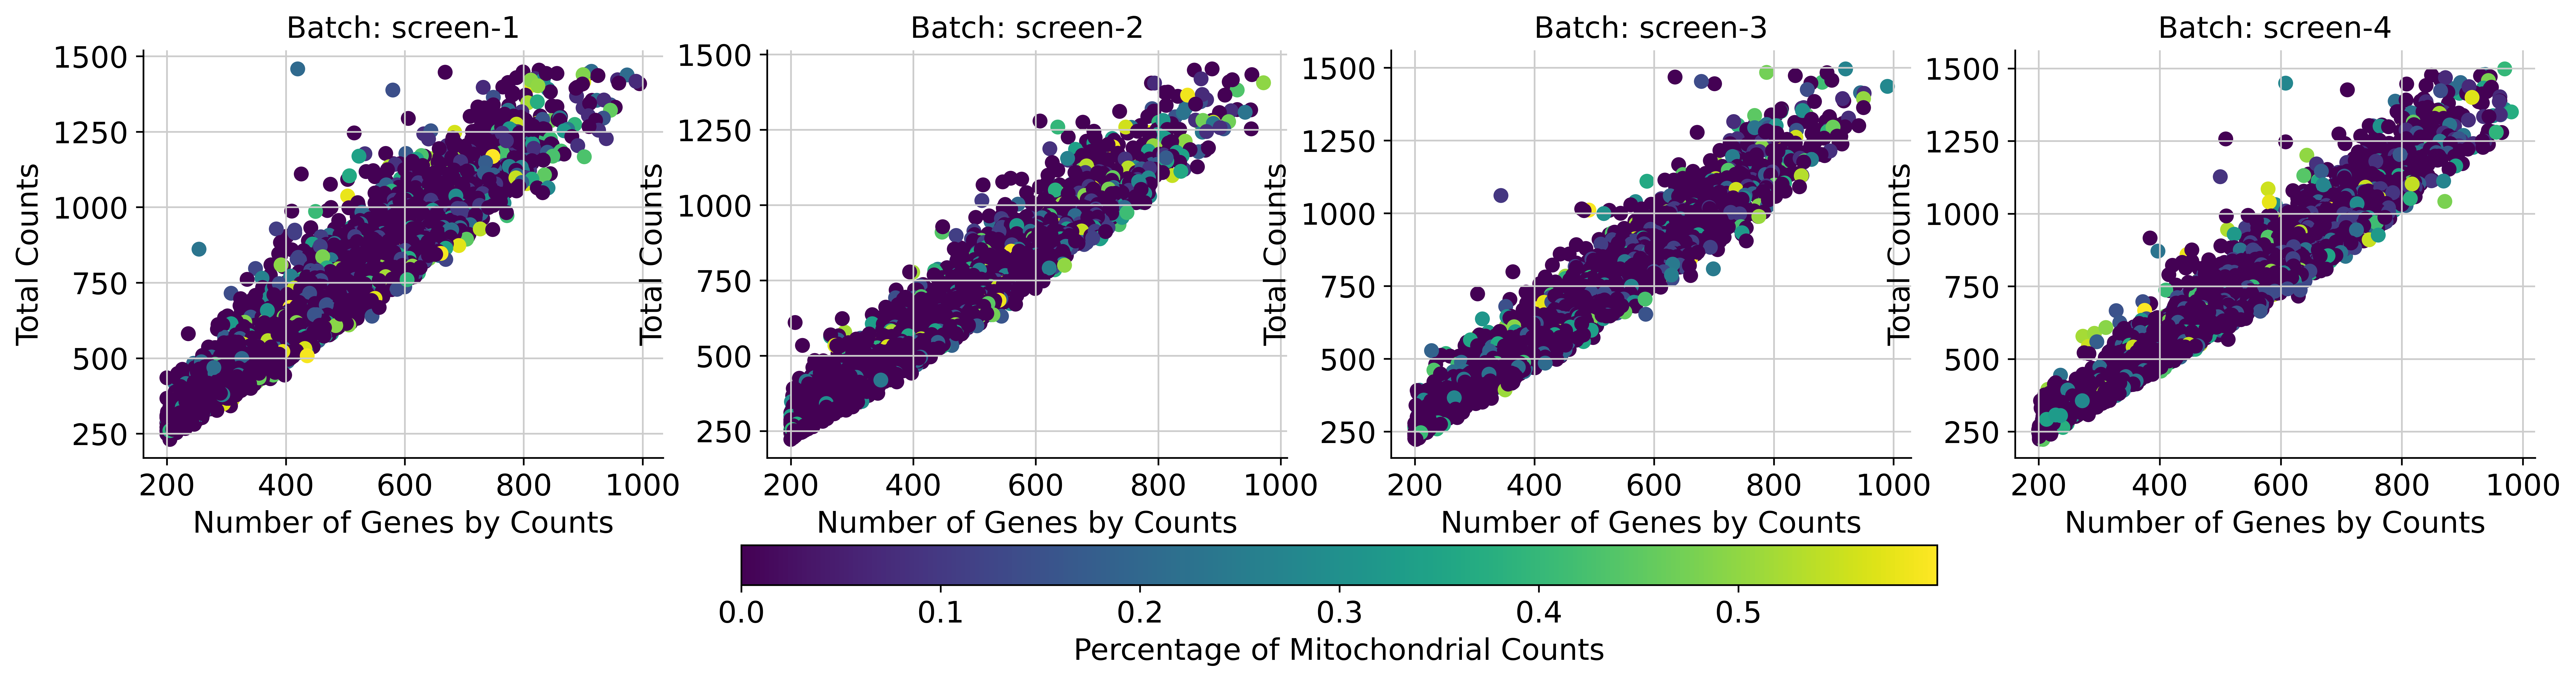

In [11]:
# Set up the figure for subplots
batches = adata.obs['batch'].unique()
fig, axs = plt.subplots(1, len(batches), figsize=(5 * len(batches), 5))

# Generate scatter plots for each batch
for i, batch in enumerate(batches):
    batch_data = adata[adata.obs['batch'] == batch]
    scatter = axs[i].scatter(
        batch_data.obs['n_genes'],
        batch_data.obs['total_counts'],
        c=batch_data.obs['pct_counts_mt'],
        cmap='viridis'
    )
    axs[i].set_title(f'Batch: {batch}')
    axs[i].set_ylabel('Total Counts')
    axs[i].set_xlabel('Number of Genes by Counts')

# Add a colorbar
cbar = fig.colorbar(scatter, ax=axs, orientation='horizontal', pad=0.15, aspect=30, shrink=0.5)
cbar.set_label('Percentage of Mitochondrial Counts')

#plt.tight_layout()
plt.show()

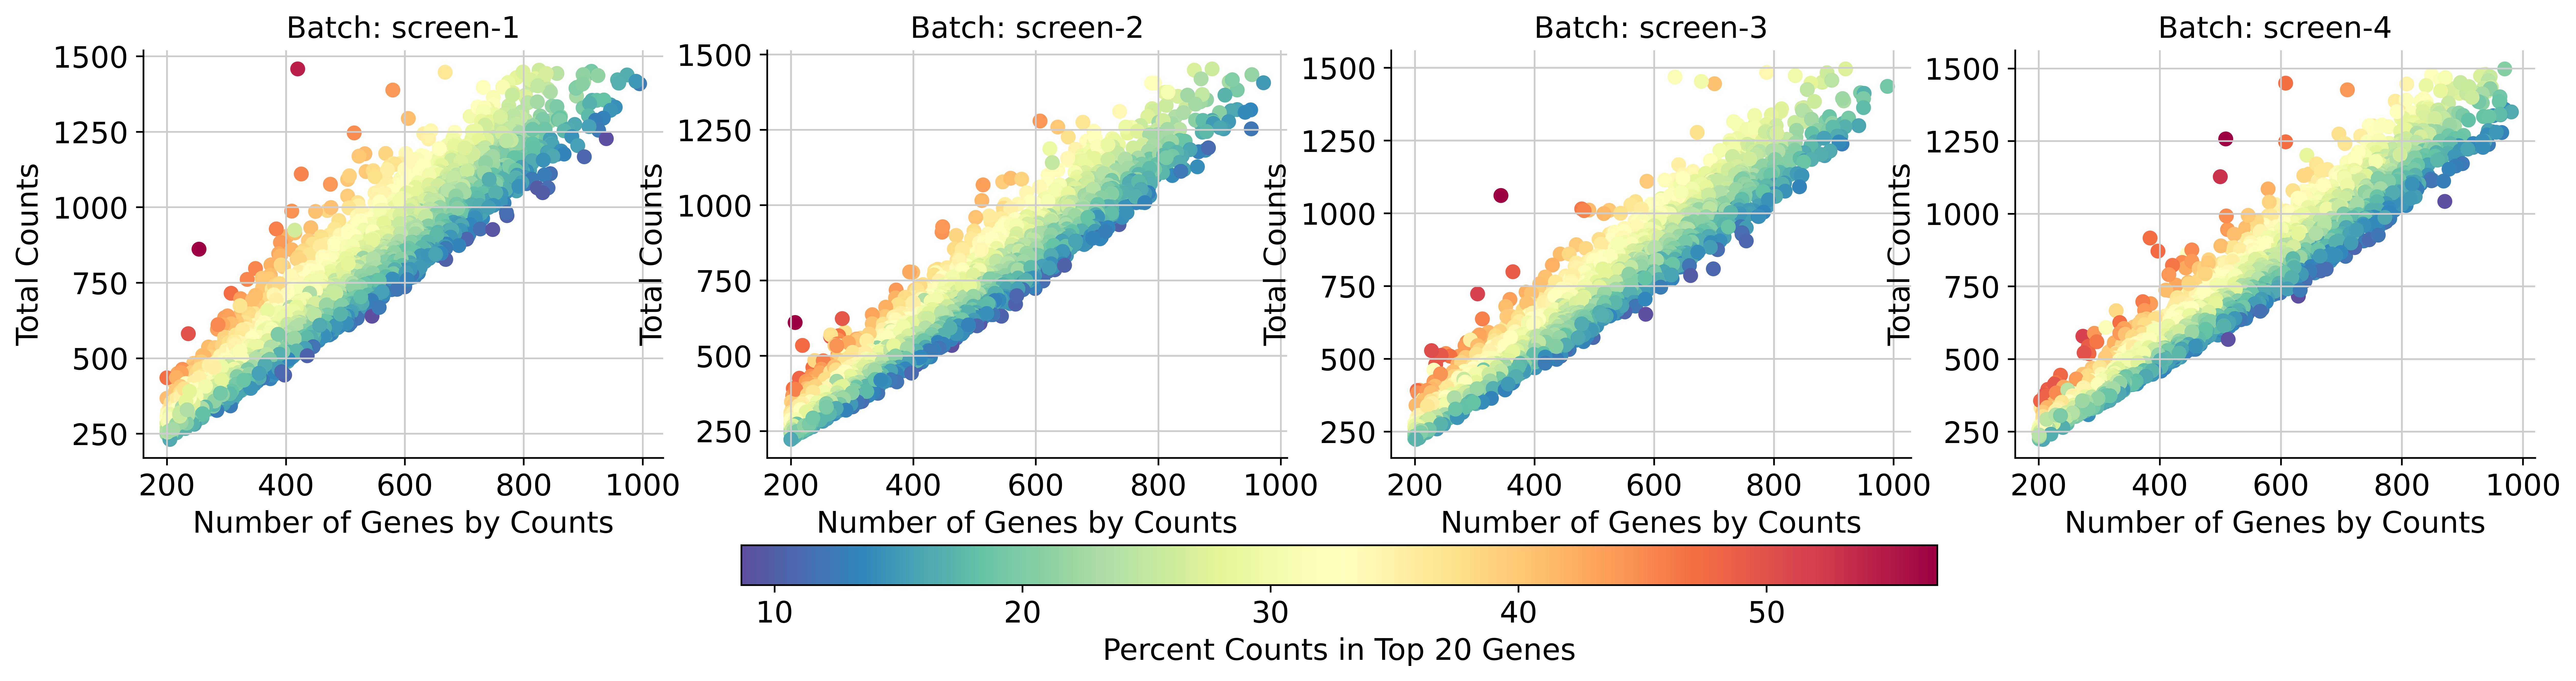

In [12]:
# Set up the figure for subplots
batches = adata.obs['batch'].unique()
fig, axs = plt.subplots(1, len(batches), figsize=(5 * len(batches), 5))

# Generate scatter plots for each batch
for i, batch in enumerate(batches):
    batch_data = adata[adata.obs['batch'] == batch]
    scatter = axs[i].scatter(
        batch_data.obs['n_genes'],
        batch_data.obs['total_counts'],
        c=batch_data.obs['pct_counts_in_top_20_genes'],
        cmap='Spectral_r'
    )
    axs[i].set_title(f'Batch: {batch}')
    axs[i].set_ylabel('Total Counts')
    axs[i].set_xlabel('Number of Genes by Counts')

# Add a colorbar
cbar = fig.colorbar(scatter, ax=axs, orientation='horizontal', pad=0.15, aspect=30, shrink=0.5)
cbar.set_label('Percent Counts in Top 20 Genes')

#plt.tight_layout()
plt.show()

### Remove the mitochondrial genes

In [13]:
# Identify mitochondrial genes
mitochondrial_genes = adata.var_names.str.startswith('mt-')
ribosomal_genes = adata.var_names.str.startswith("Rpl") | adata.var_names.str.startswith("Rps")

In [14]:
print(sum(mitochondrial_genes))
print(sum(ribosomal_genes))

11
198


In [15]:
# Create a boolean mask for genes to keep
genes_to_keep = ~(mitochondrial_genes | ribosomal_genes)

# Subset the AnnData object to keep only the desired genes
adata_filtered = adata[:, genes_to_keep].copy()

In [16]:
adata_filtered

AnnData object with n_obs × n_vars = 20081 × 24415
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'gene_expression_encoding'
    layers: 'spliced', 'unspliced'

In [ ]:
adata = adata_filtered.copy()
print(adata)
del adata_filtered

AnnData object with n_obs × n_vars = 20081 × 24415
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'gene_expression_encoding'
    layers: 'count', 'spliced', 'unspliced'

In [18]:
output_dir = '/home/johnathan/projects/arrenkiel_scrnaseq/test/scrna/results/'

In [19]:
adata = sc.read_h5ad(os.path.join(output_dir, 'integrated_filtered_noMtRpl.h5ad'))

In [21]:
# save the raw counts
adata.layers['count'] = adata.X
adata.write(os.path.join(output_dir, 'integrated_filtered_noMtRpl.h5ad'))

### LogNorm and HVG

In [22]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = False,
                             flavor = 'cell_ranger',
                             batch_key = 'batch')

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [23]:
print(adata)
print(adata.X)

AnnData object with n_obs × n_vars = 20081 × 24415
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'hvg'
    obsm: 'gene_expression_encoding'
    layers: 'count', 'spliced', 'unspliced'
  (0, 64)	2.0724728723637424
  (0, 281)	2.0724728723637424
  (0, 297)	2.0724728723637424
  (0, 328)	2.0724728723637424
  (0, 336)	2.0724728723637424
  (0, 337)	2.0724728723637424
  (0, 509)	2.0724728723637424
  (0, 605)	2.0724728723637424
  (0, 683)	2.0724728723637424
  (0,

In [24]:
adata.raw = adata.copy()
adata = adata[:,adata.var.highly_variable]

In [25]:
adata.raw

In [26]:
sc.tl.pca(adata, svd_solver = 'arpack')

computing PCA
    with n_comps=50
    finished (0:00:01)


## Batch correction with scvi-tools
### Remove the covariates because tendency to overcorrect

In [27]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="count",
    batch_key="batch",    
    #continuous_covariate_keys=['total_counts', "pct_counts_mt", "pct_counts_ribo"], # with this don't need to regress out covariates
)

In [28]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train(accelerator = 'gpu')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A30') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 398/398: 100%|██████████| 398/398 [11:22<00:00,  1.71s/it, v_num=1, train_loss_step=162, train_loss_epoch=162]

`Trainer.fit` stopped: `max_epochs=398` reached.


Epoch 398/398: 100%|██████████| 398/398 [11:22<00:00,  1.72s/it, v_num=1, train_loss_step=162, train_loss_epoch=162]


In [29]:
SCVI_LATENT_KEY = "X_scvi"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [30]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [31]:
SCVI_NORMALIZED_KEY = "scvi_normalized"
adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size = 10e4)

In [32]:
adata.layers['scvi_normalized_log'] = np.log1p(adata.layers['scvi_normalized'])

In [33]:
print(adata.X)

  (0, 60)	2.0724728723637424
  (0, 128)	2.0724728723637424
  (0, 227)	6.709846198846469
  (0, 228)	4.836281906951478
  (0, 494)	2.0724728723637424
  (0, 509)	2.0724728723637424
  (0, 739)	5.832696743267762
  (0, 806)	2.0724728723637424
  (0, 893)	5.5254529391317835
  (0, 910)	2.0724728723637424
  (0, 1104)	3.7534179752515073
  (0, 1107)	4.348843215883641
  (0, 1117)	4.779590237577413
  (0, 1118)	2.0724728723637424
  (0, 1388)	2.700615222614692
  (0, 1437)	3.5757729663414546
  (0, 1453)	2.0724728723637424
  (0, 1577)	2.0724728723637424
  (0, 1842)	2.0724728723637424
  (0, 1856)	2.0724728723637424
  (0, 2044)	2.0724728723637424
  (0, 2067)	2.0724728723637424
  (0, 2157)	2.0724728723637424
  (0, 2193)	2.700615222614692
  (0, 2227)	2.0724728723637424
  :	:
  (20080, 1959)	3.9028548928343354
  (20080, 2010)	3.9028548928343354
  (20080, 2071)	3.9028548928343354
  (20080, 2072)	4.585858700198096
  (20080, 2136)	3.9028548928343354
  (20080, 2210)	3.9028548928343354
  (20080, 2258)	3.9028548928

In [34]:
print(adata.layers['scvi_normalized_log'])

[[8.73826735e-04 2.56326366e-05 4.06390196e-03 ... 4.59383130e-02
  7.61420950e-02 3.57358553e-03]
 [1.45764672e-04 6.14217371e-02 1.26703948e-01 ... 5.29506922e-01
  1.63713980e+00 1.61254760e-02]
 [7.18183932e-04 5.53142428e-01 3.89114499e+00 ... 8.27771366e-01
  9.86707091e-01 3.62959957e+00]
 ...
 [1.07628815e-02 2.00734067e+00 9.14013088e-02 ... 5.19742429e-01
  2.20122528e+00 1.38610768e+00]
 [9.94679867e-04 1.22377694e+00 1.91403250e-03 ... 2.20092043e-01
  9.44910884e-01 9.24950540e-02]
 [4.25017774e-02 2.57037425e+00 2.46746652e-02 ... 3.54610205e-01
  1.58912230e+00 7.86649346e-01]]


In [ ]:
# don't need this unless we need batch-corrected expression values
#adata.layers['spliced_norm'] = adata.X
#adata.X = adata.layers['scvi_normalized']

In [35]:
rsc.pp.neighbors(adata, n_neighbors = 20, use_rep=SCVI_LATENT_KEY)
rsc.tl.umap(adata)

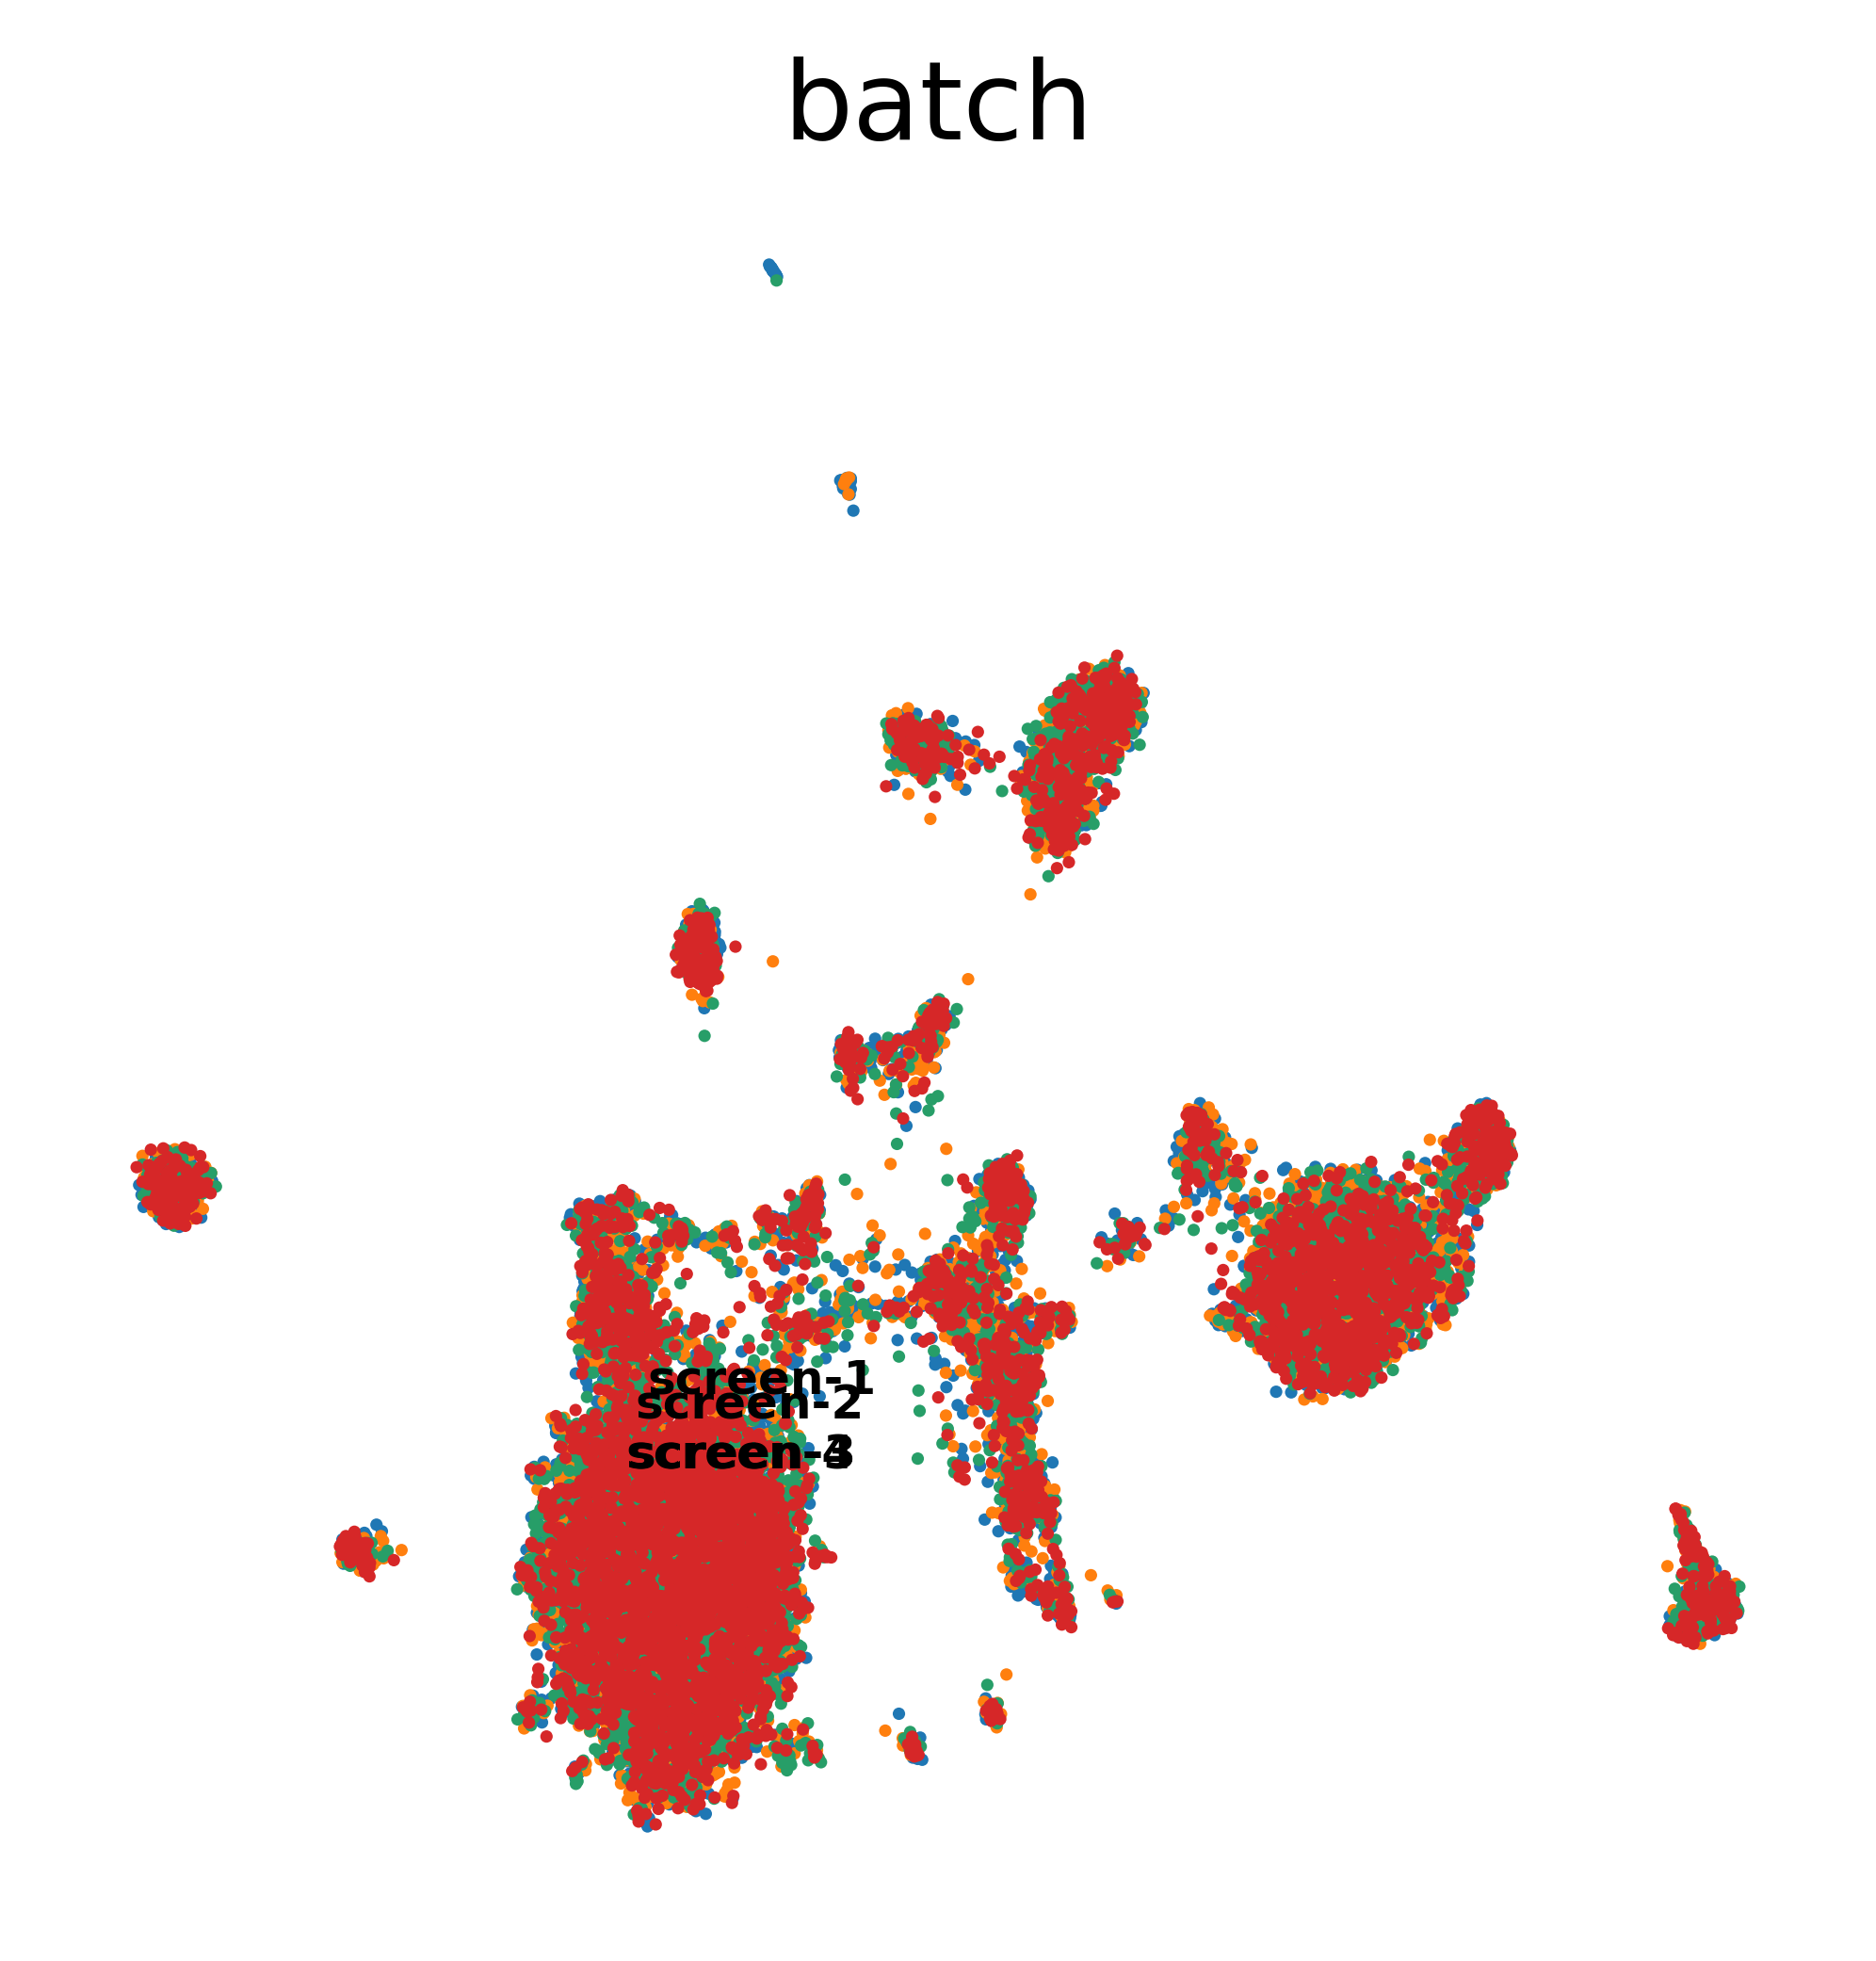

In [37]:
sc.pl.umap(adata, color = ['batch'], **kwargs)

In [ ]:
# need to write this to a file to save some of the counts and stuff...

# Begin Annotation Process with Cluster Marker Tables and Feature Plots

### Marker genes

In [38]:
marker_genes = {
    'DPC' : ['Ascl3', 'Kit', 'Cftr'],
    'iOSN' : ['Cntn1', 'Gap43', 'Dbn1', 'Ezh2', 'Ppp2cb', 'Sox11', 'Stmn1',
               'Neurod1', 'Lhx2', 'Gap43', 'Gng8', 'Dcx', 'Tubb3', 'Stmn2'],
    'mSus' : ['Ackr3', 'Muc2', 'Cyp2g1', 'Slc2a3',
              'Sox2', 'Vim', 'Gfap', 'Fabp7'],
    'iSus': ['Mybl1', 'Lgr5'],
    'SCC' : ['Trpm5'],
    'VNO' : ['Gnai2', 'Casp3'],
    'dOEC' : ['Sox10'],
    'BowmG' : ['Aqp5', 'Sox9', 'Muc5b', 'Bpifa1'],
    'mOEC' : ['Nell2', 'Plp1', 'Sox5', 'Ptprz1', 'Ptn', 'Alx3', 'Mmd2'],
    'Schwann' : ['Mbp'],
    'OECPC' : ['Ptgds', 'Sox10'],
    'PG' : ['Reln'],
    'HBC' : ['Ccnd1', 'Hes6', 'Kit', 'Mybl1', 'Tead2', 'Lgr5', 'Mki67', 'Ezh2', 
             'Trp63', 'Krt5', 'Krt14', 'Krt17', 'Ngfr', 'Itga6', 'Itgb4'],
    'Chond' : ['Alx1', 'Tfap2b', 'Carmn'],
    'OsteoB' : ['Spp1', 'Alpl', 'Runx2'],
    'OsteoC' : ['Tnfrsf11a'],
    'VE' : ['Flt1', 'Vwf', 'Lgr5'],
    'APC' : ['Mki67', 'Cd24a'],
    'mOSN' : ['Ano2', 'Olfm1', 'Chga', 'Kcnk10', 'Cnga2', 'Omp', 'Dcx', 'Dpysl5', 'Dpysl2', 'Hdac2',
            'Lhx2', 'Ncam2','Gng13', 'Ano2', 'S100a5', 'Acsm4', 'Gnal', 'Gucy2d'],
    'GBC' : ['Sox11', 'Kit', 'Ascl1', 'Sox2', 'Neurod1', 'Neurog1', 'Hes6'],
    'ACC' : ['Foxj1', 'Cdhr3', 'Cdhr4'],
    'VSM' : ['Rgs5'],
    'OVC' : ['Hepacam2', 'Cftr', 'Ascl3', 'Epcam', 'Cldn3'],
    'Fibroblasts': ['Col1a1', 'Col1a2', 'Pdgfra', 'Vim'],
}

In [39]:
old_marker_genes = {
    'HBC': ['Trp63', 'Krt5', 'Krt14', 'Krt17', 'Ngfr', 'Itga6', 'Itgb4'],
    'GBC': ['Kit', 'Ascl1', 'Sox2', 'Dlx1'],
    'iOSN': ['Neurod1', 'Lhx2', 'Gap43', 'Gng8', 'Dcx', 'Tubb3', 'Stmn1', 'Stmn2'],
    'mOSN': ['Omp', 'Cnga2', 'Gng13', 'Ano2', 'Chga', 'S100a5', 'Olfm1', 'Acsm4', 'Gnal', 'Gucy2d'],
    'Sus': ['Cyp2g1', 'Sox2', 'Vim', 'Gfap', 'Fabp7'],
    'MV': ['Ascl3', 'Cftr', 'Trpm5', 'Sox9', 'Espn', 'Plcb2'],
    'Goblet': ['Muc2', 'Muc5ac', 'Spdef'],
    'SmoothM': ['Carmn', 'Acta2', 'Myh11', 'Des', 'Tagln', 'Cnn1'],
    'Bowman': ['Muc5b', 'Lyz1', 'Bpifa1'],
    'Macrophages': ['Adgre1', 'Itgam', 'Csf1r', 'Mrc1'],
    'T_Cells': ['Cd3e', 'Cd4', 'Cd8a'],
    'B_Cells': ['Cd19', 'Ms4a1'],
    'Dendritic_Cells': ['Itgax', 'Cd86', 'Cd80'],
    'Neutrophils': ['Ly6g', 'Mpo', 'S100a8', 'S100a9'],
    'Pericytes': ['Pdgfrb', 'Anpep', 'Acta2', 'Des'],
    'Endothelial': ['Pecam1', 'Vwf', 'Cdh5', 'Esm1'],
    'Fibroblasts': ['Col1a1', 'Col1a2', 'Pdgfra', 'Vim'],
    'Glial': ['S100b', 'Sox10', 'Ngfr'],
    'Erythrocytes': ['Hba-a1'],
    'NK_Cells': ['Klrb1c', 'Ncr1', 'Gzmb', 'Prf1', 'Ifng', 'Itgam', 'Itgax']
}

## Feature Plots and Dot Plots

In [40]:
annotation_output_dir = '/home/johnathan/projects/arrenkiel_scrnaseq/test/scrna/results/annotations/figs'
markertable_output_dir = '/home/johnathan/projects/arrenkiel_scrnaseq/test/scrna/results/annotations/clustermarkertables'

In [41]:
resolutions = [0.1, 0.5, 1, 1.5, 2, 3, 8, 10] # add higher resolutions for downstream
for res in resolutions:
    rsc.tl.leiden(adata, resolution = res, key_added = 'leiden_'+str(res))

In [42]:
print(adata.obsm)
print(adata.shape)

AxisArrays with keys: gene_expression_encoding, X_pca, X_scvi, X_umap
(20081, 3000)


In [43]:
leiden_resolutions = ['leiden_0.1', 'leiden_0.5', 'leiden_1',
                      'leiden_1.5', 'leiden_2', 'leiden_3',
                      'leiden_8', 'leiden_10']

In [44]:
for res in leiden_resolutions:
    full_dotplot = sc.pl.dotplot(adata, marker_genes, 
                                groupby=res, use_raw = True, 
                                standard_scale="var", swap_axes = True, 
                                show = True, return_fig = True)
    full_dotplot.savefig(os.path.join(annotation_output_dir, 'dotplots', 
                                f"{res}_allcelltypes_dotplot.png"),
                                dpi = 300,
                                bbox_inches = 'tight')
    plt.close()

In [48]:
for res in leiden_resolutions:
    for ct in marker_genes:
        dp = sc.pl.dotplot(adata, var_names = marker_genes[ct],
                            groupby=res, use_raw = True, 
                            standard_scale = "var",swap_axes = False,
                            show = True, return_fig = True)
        dp.savefig(os.path.join(annotation_output_dir, 'dotplots', 
                                            f"{res}_{ct}_dotplot.png"),
                                            dpi = 300,
                                            bbox_inches = 'tight')
        plt.close()

In [49]:
for ct in marker_genes:
    fp = sc.pl.umap(adata,
            color = marker_genes[ct],
            frameon = False, legend_loc = 'on data',
            cmap = 'Reds', ncols = 2, show = False,
            return_fig = True)
    fp.savefig(os.path.join(annotation_output_dir, 'featureplots', 
                                        f"{ct}_featureplot.png"),
                                        dpi = 300,
                                        bbox_inches = 'tight')
    plt.close()

In [51]:
for res in leiden_resolutions:
    full_dotplot = sc.pl.dotplot(adata, old_marker_genes, 
                                groupby=res, use_raw = True, 
                                standard_scale="var", swap_axes = True, 
                                show = True, return_fig = True)
    full_dotplot.savefig(os.path.join(annotation_output_dir, 'dotplots', 
                                f"{str(res)}_allcelltypes_dotplot2.png"),
                                dpi = 300,
                                bbox_inches = 'tight')
    plt.close()

In [55]:
for res in leiden_resolutions:
    for ct in old_marker_genes:
        dp = sc.pl.dotplot(adata, var_names = old_marker_genes[ct],
                            groupby=res, use_raw = True, 
                            standard_scale = "var",swap_axes = False,
                            show = True, return_fig = True)
        dp.savefig(os.path.join(annotation_output_dir, 'dotplots', 
                                f"{res}_{ct}_dotplot2.png"),
                                dpi = 300,
                                bbox_inches = 'tight')
        plt.close()

In [56]:
for ct in old_marker_genes:
    fp = sc.pl.umap(adata,
            color = old_marker_genes[ct],
            frameon = False, legend_loc = 'on data',
            cmap = 'Reds', ncols = 2, show = False,
            return_fig = True)
    fp.savefig(os.path.join(annotation_output_dir, 'featureplots', 
                                        f"{ct}_featureplot2.png"),
                                        dpi = 300,
                                        bbox_inches = 'tight')
    plt.close()

## Cluster Marker Tables

In [60]:
def save_cluster_markers(adata, resolution, filename):
    clustering_key = resolution
    #clustering_key = 'leiden_'+str(resolution)
    sc.tl.rank_genes_groups(adata, groupby=clustering_key, method='wilcoxon', key_added = 'dea'+clustering_key)
    # Create a dataframe with the results
    result = adata.uns['dea'+clustering_key]
    groups = result['names'].dtype.names
    markers = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
         for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
    # Save to CSV
    markers.to_csv(filename, index=False)

In [62]:
for res in leiden_resolutions:
    filename = f'cluster_markers_{res}.csv'
    save_cluster_markers(adata, res, os.path.join(markertable_output_dir,filename))
    print(f'Saved markers for {res} to {filename}')

ranking genes
    finished: added to `.uns['dealeiden_0.1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:18)
Saved markers for leiden_0.1 to cluster_markers_leiden_0.1.csv
ranking genes
    finished: added to `.uns['dealeiden_0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)
Saved markers for leiden_0.5 to cluster_markers_leiden_0.5.csv
ranking genes
    finished: added to `.uns['dealeiden_1']`
    'names', sorted np.recarray to be indexed by group 

## Attempt actual annotations

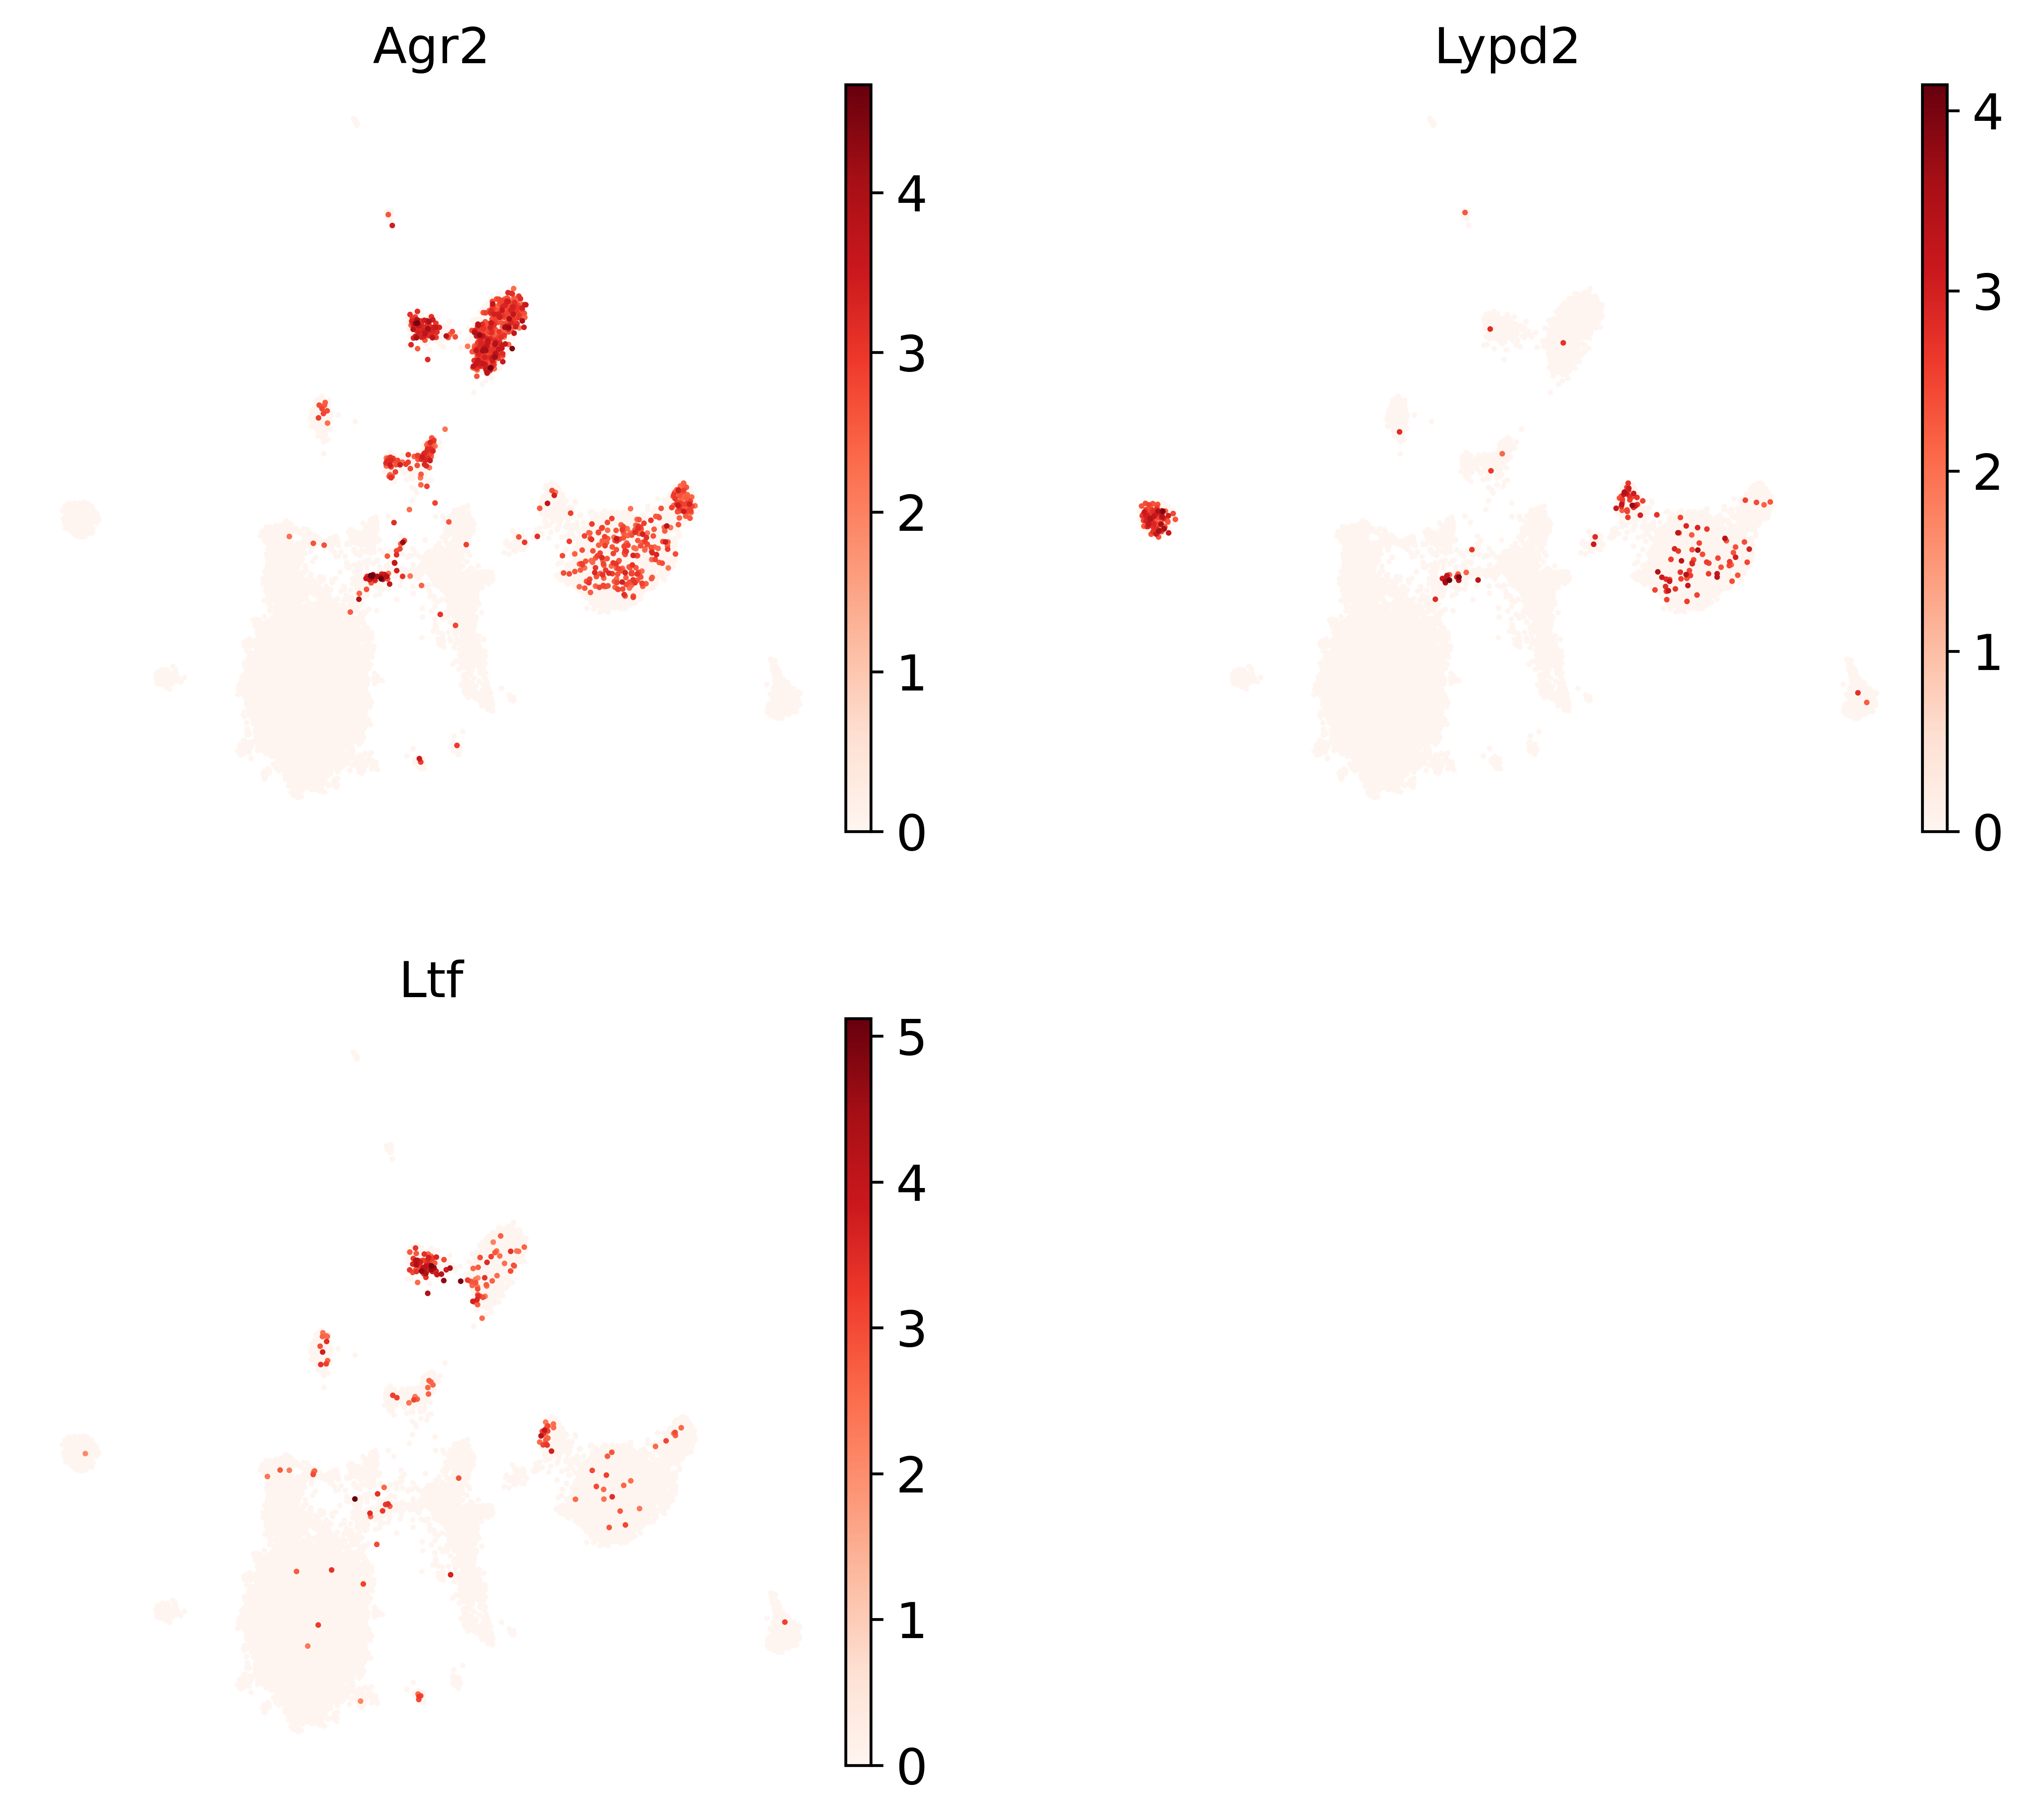

In [84]:
# mark these as Goblet
sc.pl.umap(adata, color = ['Agr2', 'Lypd2', 'Ltf'],
           **kwargs, use_raw = True, cmap = 'Reds',
           ncols = 2)

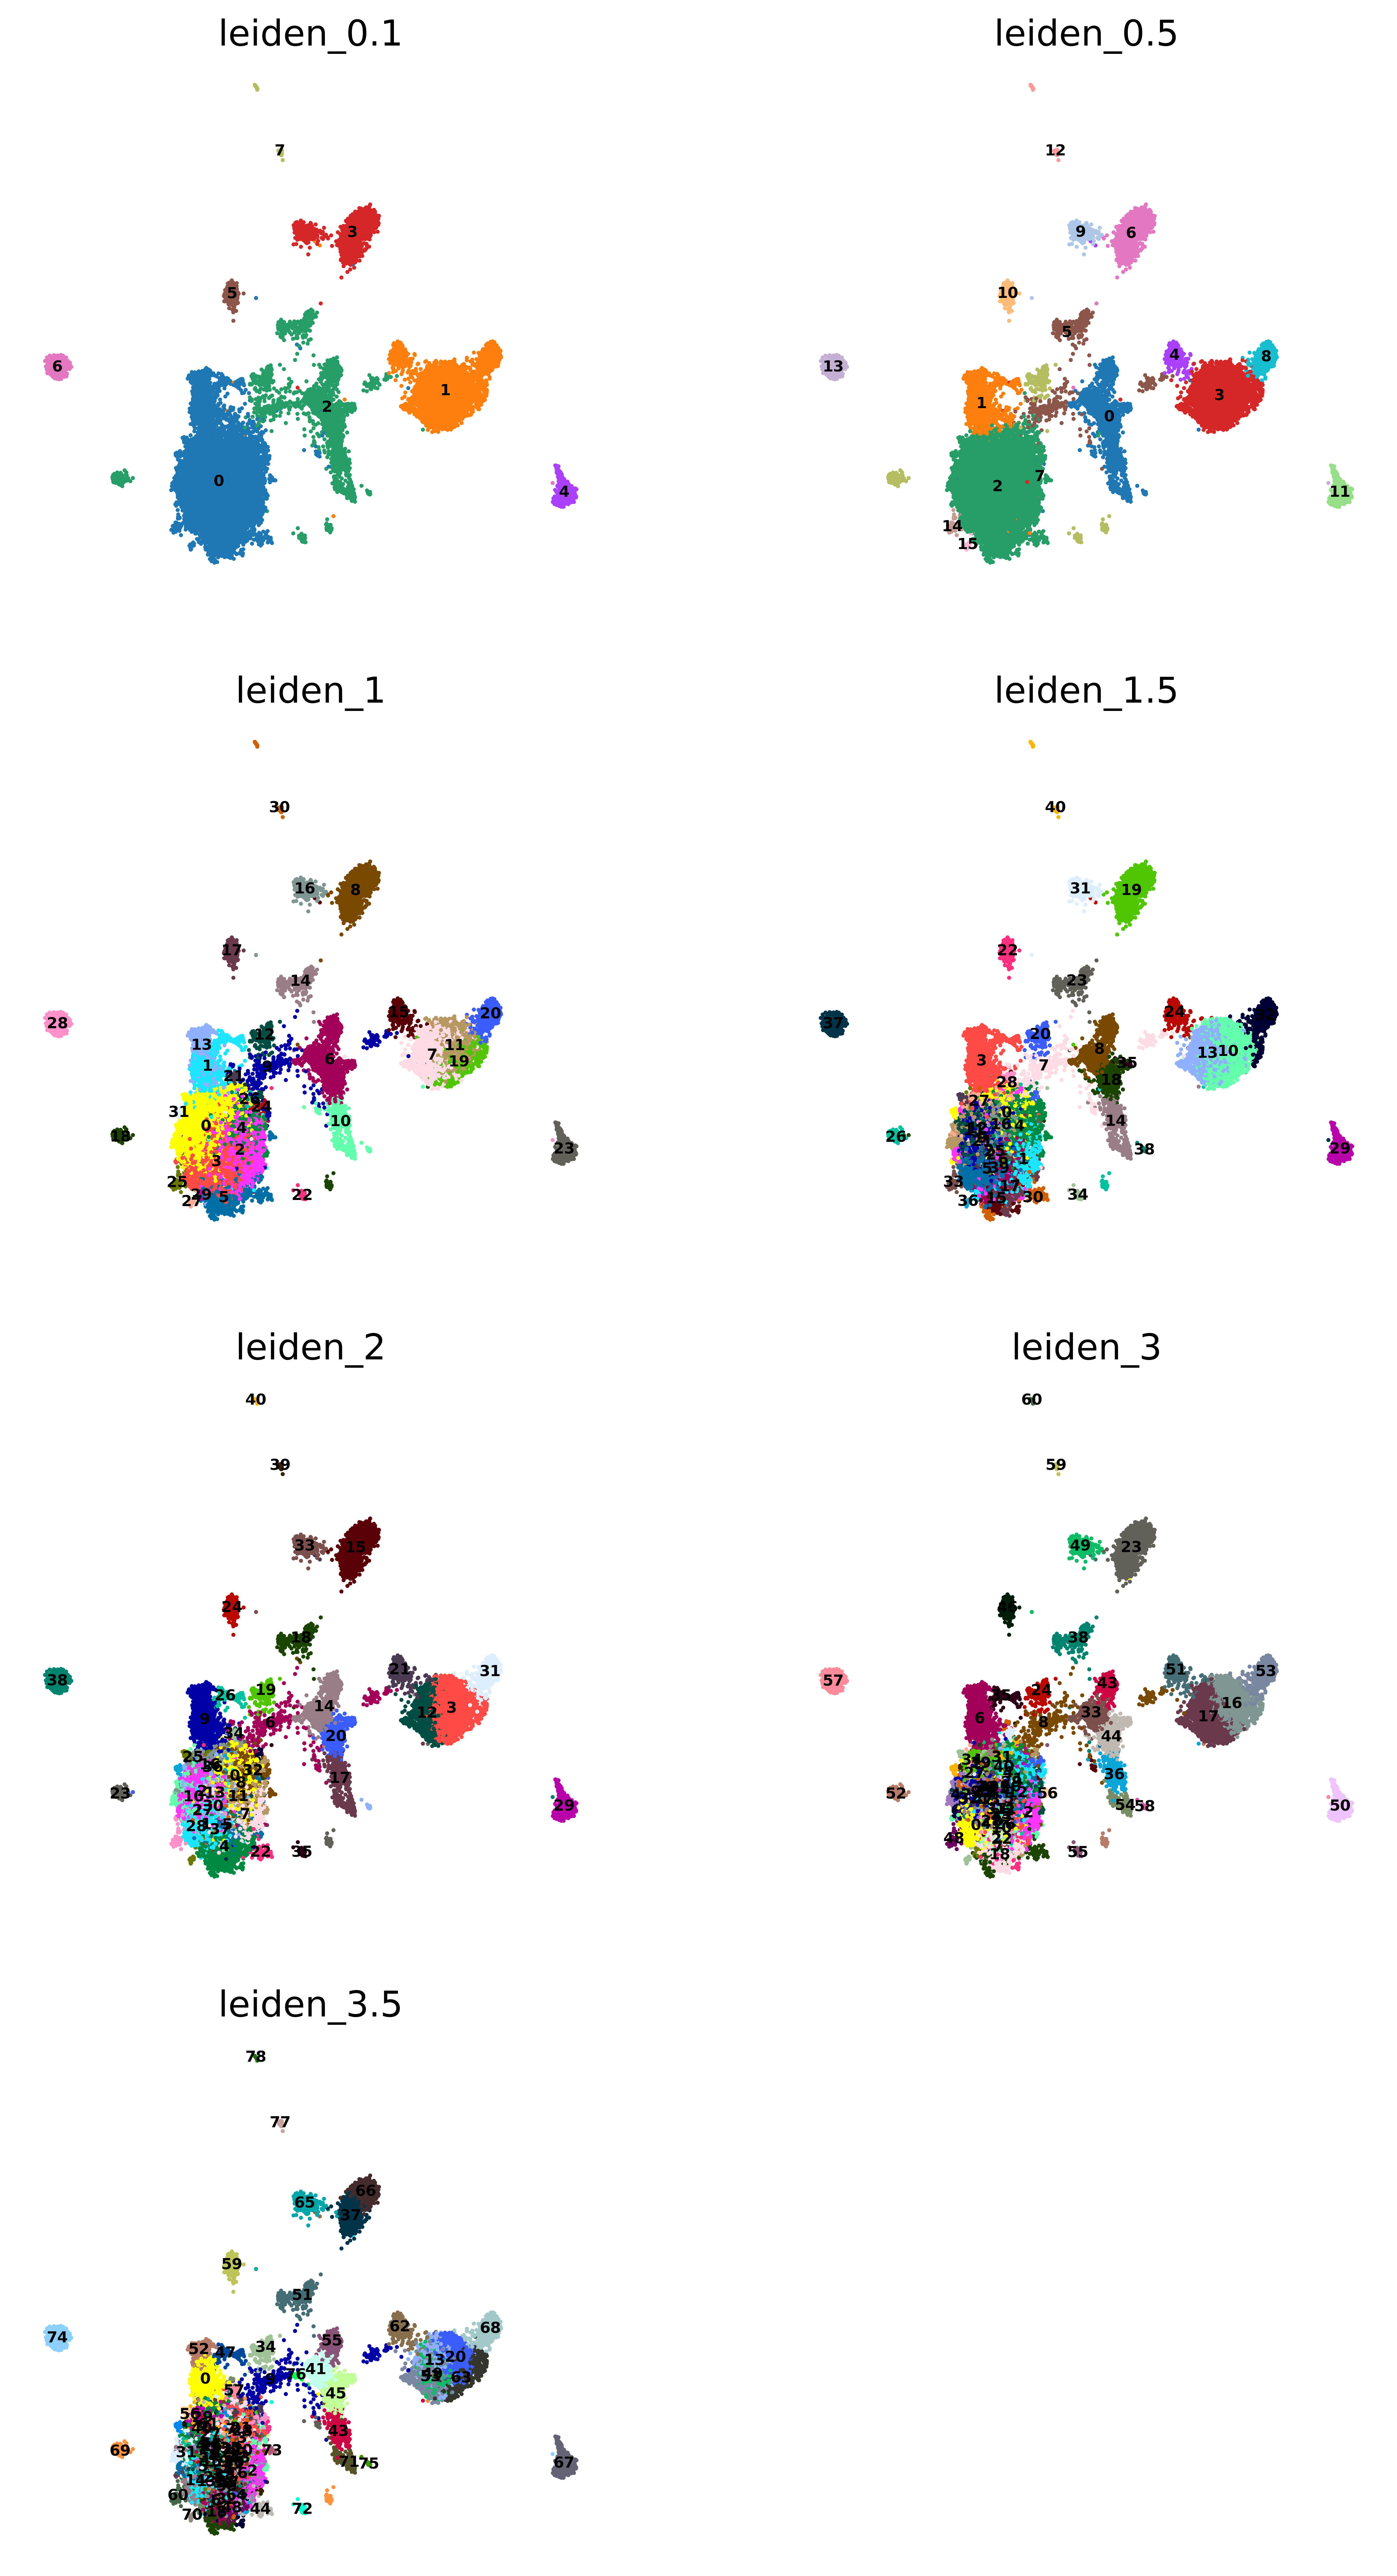

In [79]:
sc.pl.umap(adata, 
           color = ['leiden_0.1', 'leiden_0.5',
                    'leiden_1', 'leiden_1.5',
                    'leiden_2', 'leiden_3',
                    'leiden_3.5', 'leiden_8',
                    'leiden_10'],
           **kwargs,
           ncols = 2)

### UnSec = Undefined Secretory Cell
### LE = Lymphatic Epithelial Cell
### RE = Respiratory Epithelial

In [163]:
annotations_05 = {
    '13' : 'ACC',
    '10' : 'MVC',
    '6' : 'BowG',
    '4' : 'Trans?',
    '0' : 'Mes',
    '11' : 'dOEC',
    '3' : 'mSus',
    '8' : 'dSus',
    '9' : 'Gob',
    '1' : 'iOSN',
    '11' : 'mOEC',
    '7' : 'mOSN',
    '14' : 'mOSN',
    '15' : 'mOSN',
    '2' : 'mOSN',
    '12' : 'MVC'
    
}
annotations_01 = {'18' : 'VE', '22' : 'SCC', '12' : 'Immune', '14' : 'RE'}
annotations_02 = {'26' : 'GBC'}
annotations_8 = {'3' : 'UnSec', '175' : 'LE'}
annotations_10 = {'213' : 'HBC'}

In [94]:
adata.obs["celltype"] = adata.obs['leiden_0.5'].map(annotations_05)

In [162]:
new_categories = ['VE', 'SCC', 'GBC', 'HBC', 'Immune', 'Epi',
                  'RE', 'UnSec', 'LE']
adata.obs['celltype'] = adata.obs.celltype.cat.add_categories(new_categories)

In [164]:
adata.obs['celltype'].update(adata.obs['leiden_1'].map(annotations_01))
adata.obs['celltype'].update(adata.obs['leiden_2'].map(annotations_02))
adata.obs['celltype'].update(adata.obs['leiden_8'].map(annotations_8))
adata.obs['celltype'].update(adata.obs['leiden_10'].map(annotations_10))

### Checking cluster markers for leiden_8 and clusters of interest

In [161]:
result = adata.uns['dealeiden_8']
groups = result['names'].dtype.names
markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
# Extract results for clusters 25 and 22
clusters_of_interest = ['175']

# Initialize an empty list to store the DataFrames for each cluster
selected_markers = []

# Loop through each cluster of interest and filter the DataFrame
for cluster in clusters_of_interest:
    cluster_df = markers.loc[:, [col for col in markers.columns if col.startswith(cluster + '_')]]
    selected_markers.append(cluster_df)

# Combine the DataFrames for the selected clusters
selected_markers_df = pd.concat(selected_markers, axis=1)

# Display the results
print(selected_markers_df.head(20))

       175_n      175_l         175_p
0     Ccl21a  10.999699  2.286471e-14
1       Nrp2   4.655334  4.791563e-14
2      Meis2   4.191551  9.422029e-13
3      H2-K1   4.902155  1.342731e-11
4      Sned1   5.228194  7.557343e-11
5      Stab2   9.268925  2.748664e-08
6    Rapgef5   7.546615  1.606893e-07
7       Tbx1   8.735856  1.681903e-06
8      Mmrn1  10.916142  1.549782e-05
9      Macf1   1.959915  2.441888e-05
10   Slc38a2   2.545905  4.188841e-05
11     Gng11   8.517291  5.250491e-05
12     Prox1   7.500423  5.604617e-05
13      Flt4  10.381747  1.360426e-04
14     Cald1   3.808865  1.787118e-04
15     H2-D1   4.383736  1.913942e-04
16    Adgrf5   6.556271  5.212701e-04
17    Map4k2   3.836442  9.089033e-04
18     Thbs1   5.089897  1.109001e-03
19  Ralgapa2   3.279096  2.960834e-03


In [116]:
kwargs['legend_fontsize'] = 4

### Check for NA and annotate them as cluster they likely belong to

In [176]:
adata.obs.loc[adata.obs.celltype.isna()]

background_fraction  cell_probability    cell_size  \
barcode                                                                
CTTCCTTAGAGTAACT             0.132103          0.999955  1415.670776   

                  droplet_efficiency     batch  n_genes  doublet_x  \
barcode                                                              
CTTCCTTAGAGTAACT            1.202469  screen-3      850      False   

                  n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
barcode                                                                      
CTTCCTTAGAGTAACT                851                 6.747587          1176   

                  ...  leiden_4  leiden_3.5  celltype  leiden_5  leiden_10  \
barcode           ...                                                        
CTTCCTTAGAGTAACT  ...        10           9       NaN         4         42   

                  leiden_6  doublet_y   singlet  prediction  leiden_8  
barcode                                                                
CTTCCTTAGAGTAACT        30   1.701364 -1.951913     doublet        93  

[1 rows x 36 columns]

In [180]:
# Alternatively, if you want to explicitly find and replace NaNs
adata.obs.loc[adata.obs['celltype'].isna(), 'celltype'] = 'UnSec'

In [181]:
adata.obs.celltype.value_counts()

celltype
mOSN      8970
mSus      3392
Mes       1859
iOSN      1146
BowG      1125
dSus       484
mOEC       441
ACC        403
MVC        361
RE         343
Gob        323
UnSec      288
Trans?     265
Immune     233
VE         152
GBC        109
HBC         67
LE          61
SCC         59
Epi          0
Name: count, dtype: int64

### Check final UMAP

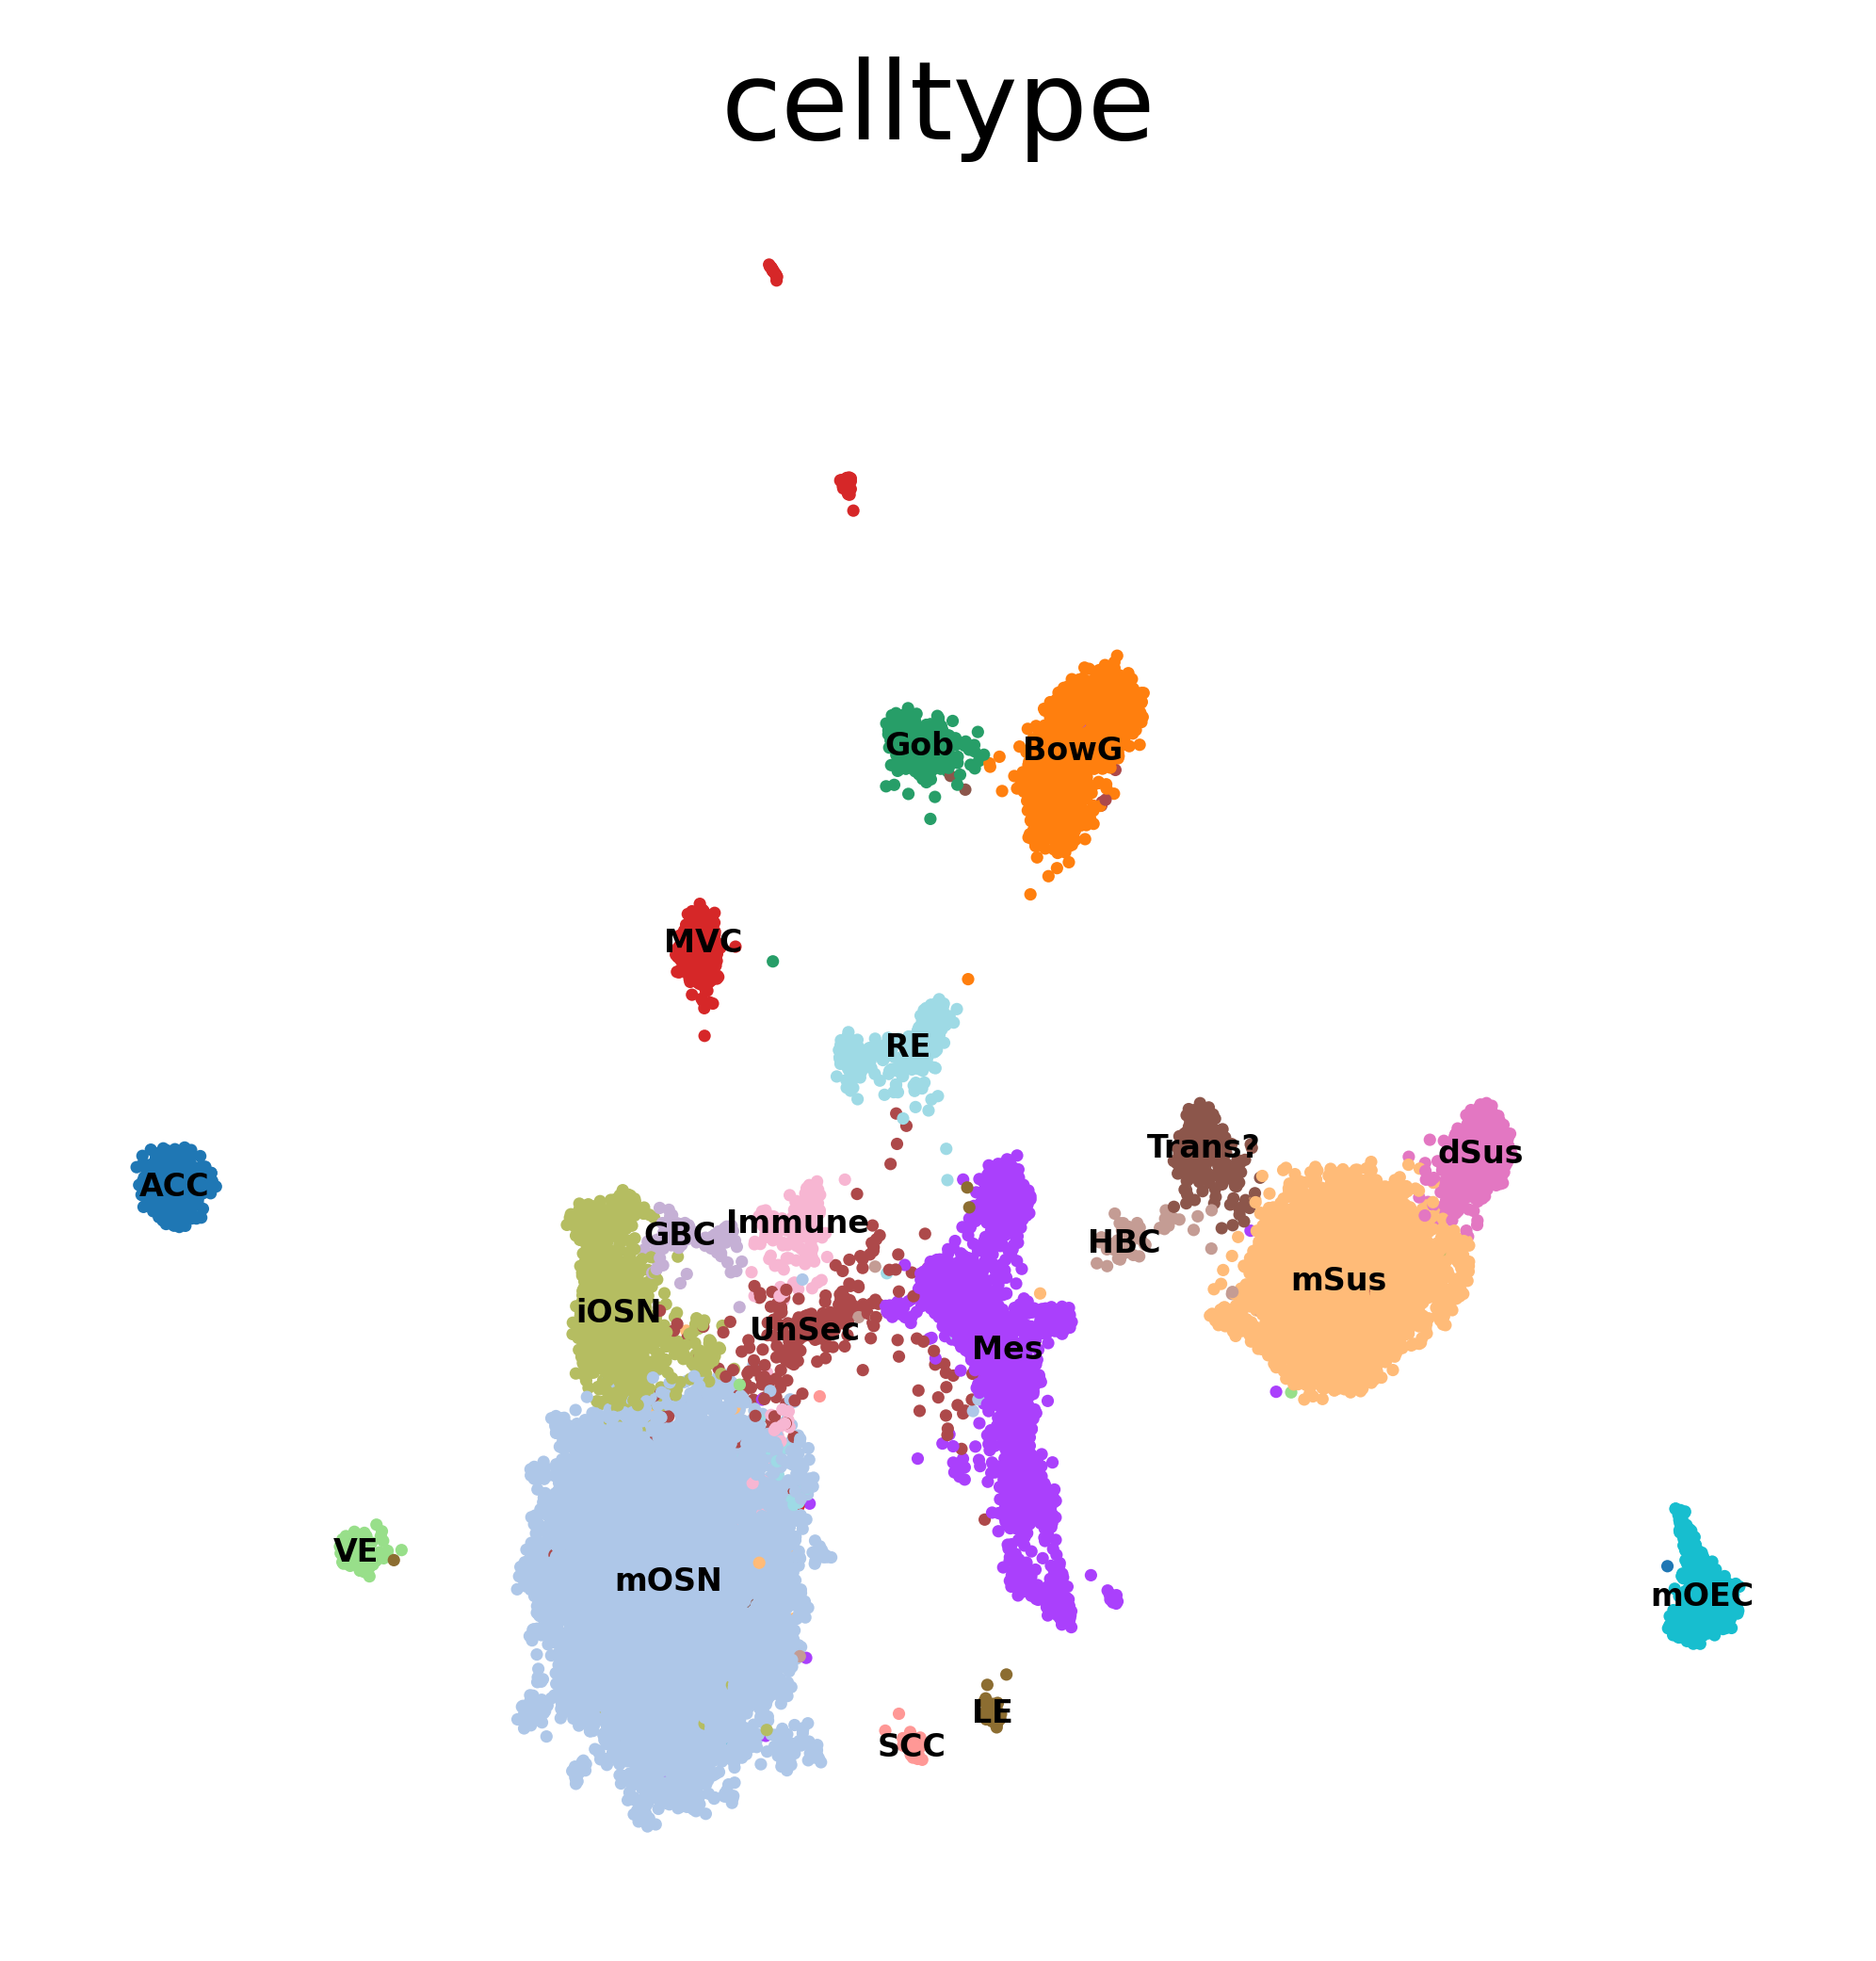

In [182]:
sc.pl.umap(adata, color = ['celltype',# 'leiden_0.5',
                           #'leiden_1', 'leiden_1.5',
                           #'leiden_3.5'
                           #'leiden_8'
                           #'leiden_2', 'leiden_4', 'leiden_10'
                           ],
           **kwargs, ncols = 2)

In [187]:
adata

AnnData object with n_obs × n_vars = 20081 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet_x', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_3.5', 'celltype', 'leiden_5', 'leiden_10', 'leiden_6', 'doublet_y', 'singlet', 'prediction', 'leiden_8'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'leiden', 'dealeiden_0.1', 'dealeiden_0.5', 'dealeiden_1', 'dealeiden_1.5', 'dealeiden_2', 'dealeiden_3', 

In [190]:
adata.write(os.path.join(output_dir, 'annotated_object_7_2_2024.h5ad'))

### Check if doublets are localized in Undefined

In [128]:
solo = scvi.external.SOLO.from_scvi_model(model)
solo.train(accelerator = 'gpu')

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 240/400:  60%|██████    | 240/400 [04:12<02:48,  1.05s/it, v_num=1, train_loss_step=0.165, train_loss_epoch=0.158] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.151. Signaling Trainer to stop.


In [129]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

In [130]:
df.groupby('prediction').count()

doublet  singlet
prediction                  
doublet        1897     1897
singlet       18184    18184

In [131]:
df

doublet   singlet prediction
CGAGGCATACAGCTAA   1.361113 -0.849928    doublet
AAGCCCTTCAAGAATG  -0.394114  0.633505    singlet
AGACAAAGCCTATATC   0.193572 -0.161425    doublet
GATGATCTTGAGAAAT  -0.065135  0.136816    singlet
CCACCCCATCAAACCA   0.595677  0.127801    doublet
...                     ...       ...        ...
ACTTTGTGGCACTCAC  -7.759091  6.813193    singlet
GCTTCACCCAACCCCT -10.586882  9.078299    singlet
AGTTTCCCATTGTAGC  -2.626251  2.399993    singlet
AGACACACAGTATTCG  -2.737422  3.075436    singlet
AGACAATCAGCGCGTT  -3.672305  4.039848    singlet

[20081 rows x 3 columns]

In [132]:
# Add the doublet information to adata_filtered.obs
adata.obs = adata.obs.merge(df, left_index=True, right_index=True, how='left')

In [133]:
adata

AnnData object with n_obs × n_vars = 20081 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet_x', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_3.5', 'celltype', 'leiden_5', 'leiden_10', 'leiden_6', 'doublet_y', 'singlet', 'prediction'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'leiden', 'dealeiden_0.1', 'dealeiden_0.5', 'dealeiden_1', 'dealeiden_1.5', 'dealeiden_2', 'dealeiden_3', 'leiden_0.1_

In [ ]:
del adata.obs['doublet_score']
del adata.obs['singlet_score']

In [ ]:
adata_filtered.obs.rename(columns = {'doublet_y' : 'doublet_score', 'singlet' : 'singlet_score',
                                     'prediction' : 'is_doublet'}, inplace = True)

In [134]:
adata.obs.prediction.value_counts()

prediction
singlet    18184
doublet     1897
Name: count, dtype: int64

### Back to annotations; Going with higher resolution to get better separation of cell types

In [ ]:
# Specify the clusters of interest
clusters_of_interest = ['1', '2', '18', '17', '0']  # Replace with your clusters of interest

# Subset the AnnData object
adata_subset = adata_filtered[adata_filtered.obs['leiden_2'].isin(clusters_of_interest)].copy()

# Generate violin plots for specific markers
markers = ['Cyp2g1', 'Muc2', 'Gfap', 'Muc5ac']  # Replace with your markers of interest

In [ ]:
sc.pl.violin(adata_subset, ['Cyp2g1', 'Muc2', 'Gfap', 'Muc5ac'], 
             scale = 'count',
             groupby='leiden_2', jitter=0.4, use_raw = False)

In [149]:
res = 'leiden_8'
f'cluster_markers_{res}.csv'
save_cluster_markers(adata, res, os.path.join(markertable_output_dir, filename))

ranking genes
    finished: added to `.uns['dealeiden_8']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:13)


In [150]:
result = adata.uns['dealeiden_8']
groups = result['names'].dtype.names
markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
# Extract results for clusters 25 and 22
clusters_of_interest = ['3', '160']

# Initialize an empty list to store the DataFrames for each cluster
selected_markers = []

# Loop through each cluster of interest and filter the DataFrame
for cluster in clusters_of_interest:
    cluster_df = markers.loc[:, [col for col in markers.columns if col.startswith(cluster + '_')]]
    selected_markers.append(cluster_df)

# Combine the DataFrames for the selected clusters
selected_markers_df = pd.concat(selected_markers, axis=1)

# Display the results
print(selected_markers_df.head(20))

          3_n       3_l           3_p      160_n     160_l         160_p
0      Tmsb4x  7.718112  1.848637e-83     Slc6a6  4.653757  3.628124e-17
1        Fth1  5.718632  5.218697e-66    Scgb1c1  3.778973  1.681552e-06
2     Scgb1c1  5.247780  6.266458e-56     Bpifa1  4.507702  2.189846e-06
3        Tpt1  6.793269  2.097946e-52   Mir205hg  5.663353  7.665474e-06
4       Calm1  3.589957  4.615142e-51       Cbr2  3.012898  1.639168e-05
5        Actb  5.509106  2.006339e-47      Car12  7.856734  2.519216e-05
6   Rn18s-rs5  2.813904  1.308741e-44      Epas1  2.631595  3.595279e-03
7      Eef1a1  6.334034  4.955752e-44     Col7a1  5.874883  5.749940e-03
8         Ubb  7.014572  6.701960e-38       Gclm  4.579628  1.197113e-02
9       H3f3b  2.753237  2.889113e-37       Aqp3  3.921587  4.389698e-02
10   Hsp90ab1  4.259262  2.427831e-35      Itm2b  3.033883  5.226689e-02
11        Fau  6.938358  1.945775e-33        Dst  1.926829  1.088303e-01
12       Ftl1  4.682110  2.651389e-30       Gclc  2

In [151]:
sc.tl.filter_rank_genes_groups(
adata,
min_in_group_fraction=0.2,
max_out_group_fraction=0.2,
key="dealeiden_8",
key_added="dealeiden_8_filtered",)


Filtering genes using: min_in_group_fraction: 0.2 min_fold_change: 1, max_out_group_fraction: 0.2


In [153]:
result = adata.uns['dealeiden_8_filtered']
groups = result['names'].dtype.names
markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
# Extract results for clusters 25 and 22
#clusters_of_interest = ['9', '12', '14']

# Initialize an empty list to store the DataFrames for each cluster
selected_markers = []

# Loop through each cluster of interest and filter the DataFrame
for cluster in clusters_of_interest:
    cluster_df = markers.loc[:, [col for col in markers.columns if col.startswith(cluster + '_')]]
    selected_markers.append(cluster_df)

# Combine the DataFrames for the selected clusters
selected_markers_df = pd.concat(selected_markers, axis=1)

# Display the results
print(selected_markers_df.head(20))

         3_n       3_l           3_p     160_n     160_l         160_p
0     Tmsb4x  7.718112  1.848637e-83       NaN  4.653757  3.628124e-17
1       Fth1  5.718632  5.218697e-66   Scgb1c1  3.778973  1.681552e-06
2    Scgb1c1  5.247780  6.266458e-56    Bpifa1  4.507702  2.189846e-06
3       Tpt1  6.793269  2.097946e-52  Mir205hg  5.663353  7.665474e-06
4        NaN  3.589957  4.615142e-51       NaN  3.012898  1.639168e-05
5       Actb  5.509106  2.006339e-47     Car12  7.856734  2.519216e-05
6        NaN  2.813904  1.308741e-44     Epas1  2.631595  3.595279e-03
7     Eef1a1  6.334034  4.955752e-44    Col7a1  5.874883  5.749940e-03
8        Ubb  7.014572  6.701960e-38      Gclm  4.579628  1.197113e-02
9        NaN  2.753237  2.889113e-37      Aqp3  3.921587  4.389698e-02
10  Hsp90ab1  4.259262  2.427831e-35     Itm2b  3.033883  5.226689e-02
11       Fau  6.938358  1.945775e-33       NaN  1.926829  1.088303e-01
12      Ftl1  4.682110  2.651389e-30      Gclc  2.926408  1.091672e-01
13    